In [ ]:
import numpy as np
import qiskit as qk
import qutip as qt
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display

In [17]:
count=0
for i in range(50):
    count+=i
print(np.arange(50)*0.05)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45]


In this lab we will implement quantum algorithms to simulate the dynamics of a Quantum Ising Chain. 
We provide some code to classically simulate the dynamics using a numerical integrator from `qutip`. Next we discuss two different simulation stratgies - First and Second order Trotter decompositions to implementing Hamiltonian simulation.

# Setting up the Problem
We would like to solve the following equation,
\begin{align}
i\frac{\partial}{\partial t}|\psi(t)\rangle=\hat{H}|\psi(t)\rangle
\end{align}
where, $\hat{H}$ describes the Hamiltonian of the Ising model,
\begin{align}
\hat{H}=\frac{1}{2}\sum_{i=0}^{N-2}J_x\sigma^x_i \sigma^x_{i+1}+\frac{1}{2}\sum_{i=0}^{N-1}h_{z}\sigma^z_{i}
\end{align}
This Hamiltonian describes a magnetic chain (or wire) consisting of $N$ magnetic atoms, where the magnetic atoms are arranged in a line. Each atom interacts with its nearest neighboring atom with the strength of the coupling given by $(J_x,J_y,J_z)$ in addition to an external magnetic field given by the vector $\vec{h}=(hx,hy,hz)$. In this lab, we set the following values for the parameters,
\begin{align}
(J_x= 2\pi ) \textrm{ and } (hz=2\pi)
\end{align}

We also set the initial state to be have all spins in the $|+\rangle$ state,
\begin{align}
|\psi(t=0)\rangle&=|+\rangle^{\otimes N}\\
&=\frac{1}{2^{N/2}}(|0\rangle+|1\rangle)\otimes(|0\rangle+|1\rangle)\otimes\cdots N\textrm{ times}
\end{align}



In particular, we will be interested in the time-dependence of the following quantity,
\begin{align}
\frac{1}{N}\left\langle \sum_{i=0}^{N-1} \sigma^z_i(t) \right\rangle=\frac{1}{N}\sum_i \langle\psi(t)| \sigma^z_i |\psi(t)\rangle
\end{align}


In condensed matter physics, this problem constitutes simulation of a 'quantum quench experiment' which has been quite influential in developing our understanding of the fundamental behavior of quantum materials.

In [ ]:
# Set the parameters globally for the model
N = 4     # number of spins
hz  = 1.0 * 2 * np.pi  # magnetic field along z
Jx = 1.0 * 2 * np.pi  # Coupling along x
Δt=0.05 # time step for integration
tlist=np.arange(50)*Δt #time values

# Classical Simulation of Ising model

In the following we provide some code that utilizes `qutip` to solve this equation. Note that in this lab, we will restrict to a system of $N=4$ spins. Because of the exponential cost to storing and processing quantum wavefunctions, with even the biggest supercomputers, this code is not practical for solving a system of more than 35 spins. 

You are welcome to try and find where your personal machine gives up :)

In [ ]:
def simulate_Ising_chain(N, Jx, Jy, Jz, hx, hy, hz, psi0, tlist):
    '''
    This function takes in the following parameters
    N = Number of spins (Integer)
    Jx, Jy, Jz = Strength of Couplings (Floating point number)
    hx, hy, hz = Strength of Magnetic field (Floating point number)
    psi0 = Initial state of the spin system
    tlist = List of times at which the wavefunction is calculated
    
    returns the expectation value of <sz(t)>
    '''
    si = qt.qeye(2)
    sx = qt.sigmax()
    sy = qt.sigmay()
    sz = qt.sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H += - 0.5 * hx * sx_list[n]
        H += - 0.5 * hy * sy_list[n]
        H += - 0.5 * hz * sz_list[n]

    # interaction terms
    for n in range(N-1):
        H += - 0.5 * Jx * sx_list[n] * sx_list[n+1]
        H += - 0.5 * Jy * sy_list[n] * sy_list[n+1]
        H += - 0.5 * Jz * sz_list[n] * sz_list[n+1]


    # evolve and calculate expectation value of sz_list
    result = qt.mesolve(H, psi0, tlist, e_ops=sz_list)
    sz_expectval=(1/N)*np.sum(np.real(result.expect),0)
    return sz_expectval

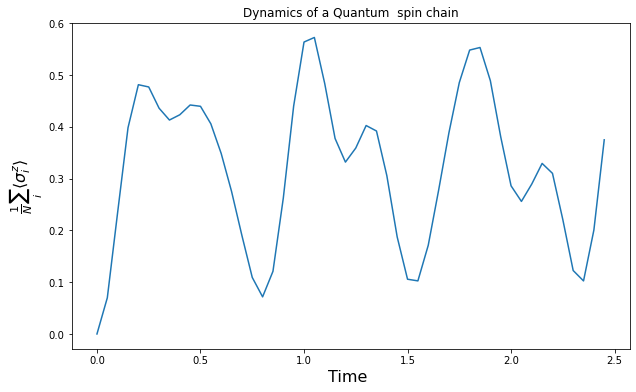

In [ ]:
# intial state, all spins in state |+>=1/sqrt(2) (|0>+|1>)
psi_plus=1/np.sqrt(2)*(qt.basis(2,0)+qt.basis(2,1)) # Create a single |+> state
psi0_list = [] # Generate a list of N |+> states
psi0_list.append(psi_plus)
for n in range(N-1):
    psi0_list.append(psi_plus)
psi0 = qt.tensor(psi0_list) # Tensor product the list to generate the initial state


sz_expt = simulate_Ising_chain(N, Jx, 0., 0., 0., 0., hz, psi0, tlist)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tlist, sz_expt)
ax.set_xlabel(r'Time ',fontsize=16)
ax.set_ylabel(r'$\frac{1}{N}\sum_i\langle \sigma^z_i \rangle$',fontsize=16)
ax.set_title(r'Dynamics of a Quantum  spin chain');

# Quantum Simulation of Ising Chain

To simulate the dynamics using the Hamiltonian Simulation we need to do the following steps
1. Prepare the Initial State
2. Realize the decomposition of the $N$ qubit unitary in terms of one and two qubit gates
3. Reconstruct the desired observable from the measurments.

In [ ]:
#Quantum computer parameters
backend = qk.Aer.get_backend('qasm_simulator')
num_shots=10000

## Prepare the initial state 

First we need to prepare an initial state that is the state $|++++\rangle$ which is the equal superposition state. Below we have left out some code for you to input the set of gates that creates an equal superposition state.

We use Hadamard gates to create the superposition state

In [ ]:
def create_initial_state(qr,cr):
    '''
    Creates the initial state for the experiment.
    Here we would like to prepare the |+>|+>|+>|+> state.
    '''
    circ = qk.QuantumCircuit(qr,cr)
    [circ.h(qr[i]) for i in range(qr.size)]
    return circ

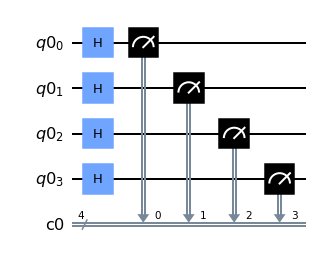

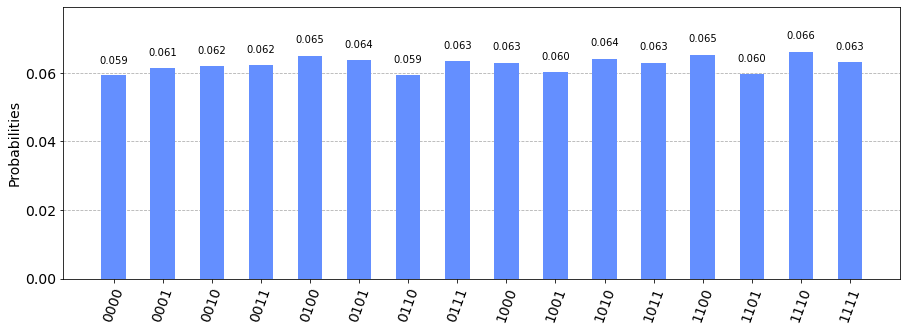

In [ ]:
# Test that the initial state created by the function is the |++++> state.
# Create a circuit and measure the output to make sure that this state is  |++++>
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ = create_initial_state(qr,cr)
circ.measure(qr,cr)
display(circ.draw('mpl'))
job = qk.execute(circ, backend=backend,shots=num_shots)
result = job.result()
qk.visualization.plot_histogram(result.get_counts(),figsize=(15,5)) #check that all states have nearly equal probability 1/16

## Creating the Unitary for two qubit interactions
Next we look at creating two-qubit interactions as desired from the Hamiltonian. The interactions in the Ising model mean that  we are interested in realizing the following general two-qubit gate,

\begin{align}
U_{\rm Ising}=e^{-\frac{i}{2}(\theta_x \sigma^x\otimes \sigma^x+\theta_y \sigma^y\otimes \sigma^y+\theta_z \sigma^z\otimes \sigma^z)}
\end{align}

For the parameters chosen in this notebook, it becomes convenient to choose the Rxx gate provided by qiskit. In general we will have to transpile an arbitrary two qubit unitary to the native gate set.

In [8]:
def unitary_ising(circ,θx,q1,q2):
    '''
    Implements the Ising unitary gate.
    Returns the standard rxx, ryy, rzz gates when two of the couplings are zero.
    '''
    circ.rxx(θx,q1, q2)
    return circ

### RXX gate

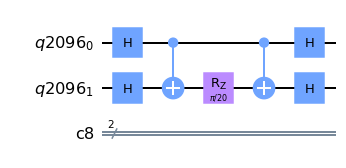

In [31]:
qr1=qk.QuantumRegister(2)
cr1=qk.ClassicalRegister(2)
circ = qk.QuantumCircuit(qr1, cr1)
circ=unitary_ising(circ,2*np.pi*Δt/2,qr1[0],qr1[1])
circ.draw('mpl');
circ_transpiled = qk.transpile(circ, backend, basis_gates=['rz','h','cx'])
circ_transpiled.draw('mpl')

## Creating the Unitary for a single Trotter step 

Now we are ready to create the Unitary operator for the Ising Hamiltonian by composing one and two qubit gates. We show the first and second order Trotter decomposition where, for $\hat{H}=\hat{A}+\hat{B}$, 
\begin{align}
e^{-i\hat{H}\Delta t}&\approx e^{-i\hat{A}\Delta t}e^{-i\hat{B}\Delta t} + O(\Delta t^2)\textrm{ (First Order Trotter)}\\
e^{-i\hat{H}\Delta t}&\approx e^{-i\hat{B}\frac{\Delta t}{2}} e^{-i\hat{A}\Delta t}e^{-i\hat{B}\frac{\Delta t}{2}}+O(\Delta t^3) \textrm{ (Second Order Trotter)}
\end{align}

### Unitary using First Order Trotter Step

In [32]:
def first_order_Trotter_unitary(circ,Δt):
    '''
    Applies a Unitary for a single time step U(Δt) using first-order trotter expansion to the input quantum circuit.
    input : circ is a quantum circuit
    output : circ-U(Δt)-
    '''
    #layer 1: coupling unitary between N and N+1
    circ.barrier()
    for p in range(0,circ.num_qubits-1,2):
        circ=unitary_ising(circ,Jx*Δt,circ.qubits[p],circ.qubits[p+1])
#         circ.rxx(Jx*Δt,circ.qubits[p],circ.qubits[p+1])
    for p in range(1,circ.num_qubits-1,2):
        circ=unitary_ising(circ,Jx*Δt,circ.qubits[p],circ.qubits[p+1])
#         circ.rxx(Jx*Δt,circ.qubits[p],circ.qubits[p+1])
    circ.barrier()
    for p in range(circ.num_qubits):    
            circ.rz(hz*Δt,circ.qubits[p])
    return circ

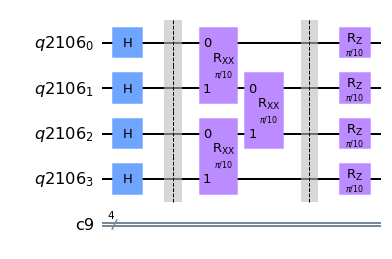

In [33]:
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ = create_initial_state(qr,cr)
circ=first_order_Trotter_unitary(circ,Δt)
# circ = qk.transpiler.passes.RemoveBarriers()(circ)
circ.draw('mpl')

### Unitary using Second Order Trotter Step 
Following the way we defined the Unitary under the first-order trotter expansion, Complete the function that implements a second order trotter expansion.

We have implemented the gates in a similar fashion to the first order trotter

In [34]:
def second_order_Trotter_unitary(circ,Δt):
    '''
    Applies a Unitary for a single time step U(Δt) using second-order trotter expansion to the input quantum circuit.
    input : circ is a quantum circuit
    output : circ-U(Δt)-
    '''
    for p in range(circ.num_qubits):
        circ.rz(hz*Δt/2,circ.qubits[p])
    #layer 1: coupling unitary between N and N+1
    circ.barrier()
    for p in range(1,circ.num_qubits-1,2):
        circ=unitary_ising(circ,Jx*Δt/2,circ.qubits[p],circ.qubits[p+1])
    for p in range(0,circ.num_qubits-1,2):
        circ=unitary_ising(circ,Jx*Δt,circ.qubits[p],circ.qubits[p+1])
    for p in range(1,circ.num_qubits-1,2):
        circ=unitary_ising(circ,Jx*Δt/2,circ.qubits[p],circ.qubits[p+1])
    circ.barrier()
    for p in range(circ.num_qubits):
        circ.rz(hz*Δt/2,circ.qubits[p])
    return circ

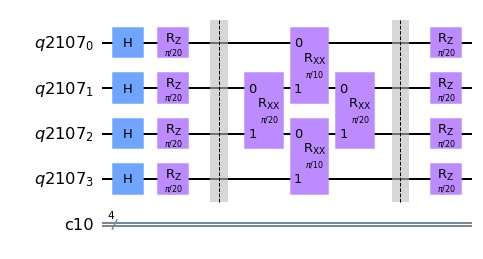

In [35]:
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ = create_initial_state(qr,cr)
circ=second_order_Trotter_unitary(circ,Δt)
# circ = qk.transpiler.passes.RemoveBarriers()(circ)
circ.draw('mpl')

## Measuring the expectation value

Finally we need to measure expectation values from probabilities of measuring in particular basis states. 
Say that we have the following state of the system of four qubits at the end of the computation,

\begin{align}
|\psi(t)\rangle=\sum_{a,b,c,d=0}^1 \sqrt{p_{abcd}}e^{i\phi_{abcd}}|abcd\rangle
\end{align}

Measuring in the computational basis states allow us to estimate p_{ijkl}. This is enough to calculate the expectation value of $\frac{1}{N}\sum_i \sigma^z_i$ because it is a diagonal operator.

We have the following expression for the observable of interest,
\begin{align}
\frac{1}{N}\sum_i \langle\psi(t)|\sigma^z_i|\psi(t)\rangle=\frac{1}{N}\sum_{abcd}p_{abcd}\left((-1)^a+(-1)^b+(-1)^c+(-1)^d\right)
\end{align}

In [1]:
def measure_z_expectval(basis_states,pz_list):
    '''
    Takes input of probabilities for states in the computational basis
    '''
    z_expectval=0
    for state,pz in zip(basis_states,pz_list):
        z_expectval+=pz*(np.mean([(-1)**int(q) for q in state]))
    return z_expectval
    

In [2]:
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ = create_initial_state(qr,cr)
circ.measure(qr,cr)
job = qk.execute(circ, backend=backend,shots=num_shots)
result = job.result()
result_counts=result.get_counts()
pz_list= [pz/num_shots for pz in result_counts.values()]
basis_states=result_counts.keys()
print('Measured expectation value of Z averaged over all qubits:'+str(measure_z_expectval(basis_states,pz_list)))

Measured expectation value of Z averaged over all qubits:0.031078125


## Bringing it all together to simulate the dynamics

Finally, let's bring together the state preparation, hamiltonian simulation and measurement to measure the required observable and compare with the classical simulation.

### First order Trotter Simulation

In [38]:
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ = create_initial_state(qr,cr)
z_expect_list1=[]
z_expect_list1.append(0) #initial value is 0
for p in range(len(tlist)-1):
    circ=first_order_Trotter_unitary(circ,Δt)
    circ.measure(qr,cr)
    job = qk.execute(circ, backend=backend,shots=num_shots)
    result = job.result()
    result_counts=result.get_counts()
    pz_list= [pz/num_shots for pz in result_counts.values()]
    basis_states=result_counts.keys()
    z_expect_list1.append(measure_z_expectval(basis_states,pz_list))
    circ.remove_final_measurements()
    circ.add_register(cr)


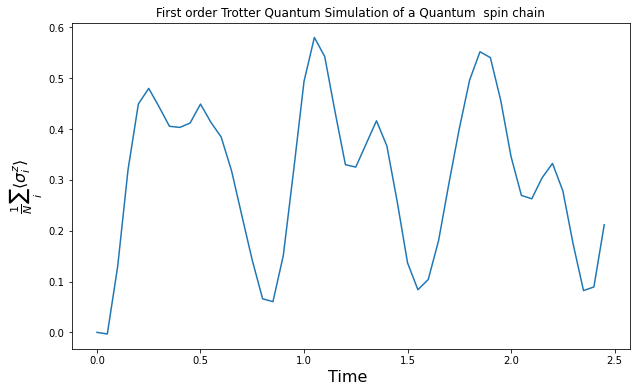

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tlist, z_expect_list1)
ax.set_xlabel(r'Time ',fontsize=16)
ax.set_ylabel(r'$\frac{1}{N}\sum_i\langle \sigma^z_i \rangle$',fontsize=16)
ax.set_title(r'First order Trotter Quantum Simulation of a Quantum  spin chain');    

### Second Order Trotter Simulation 

Once you have the implemented unitary, the following code should run it, and calculate the expecation value

The calculated dynamics are shown.

In [40]:
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ = create_initial_state(qr,cr)
z_expect_list2=[]
z_expect_list2.append(0) #initial value is 0
for p in range(len(tlist)-1):
    circ=second_order_Trotter_unitary(circ,Δt)
    circ.measure(qr,cr)
    job = qk.execute(circ, backend=backend,shots=num_shots)
    result = job.result()
    result_counts=result.get_counts()
    pz_list= [pz/num_shots for pz in result_counts.values()]
    basis_states=result_counts.keys()
    z_expect_list2.append(measure_z_expectval(basis_states,pz_list))
    circ.remove_final_measurements()
    circ.add_register(cr)


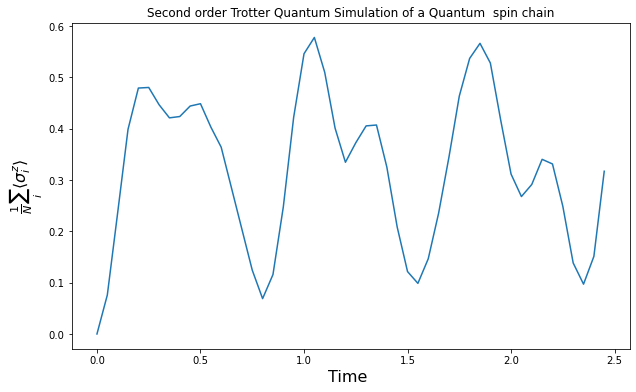

In [41]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tlist, z_expect_list2)
ax.set_xlabel(r'Time ',fontsize=16)
ax.set_ylabel(r'$\frac{1}{N}\sum_i\langle \sigma^z_i \rangle$',fontsize=16)
ax.set_title(r'Second order Trotter Quantum Simulation of a Quantum  spin chain');    

# Comparison between quantum simulation and classical simulation 

Here we compare the calculated observable as a function of time using the different method. We also compare the error in the quantum simulation as compared to exact classical simulation.

We show that first-order trotter does reasonably in comparison to the exact solution, though it shows some error. How does the second order trotter compare?

Second order performs slightly better than the first order method.

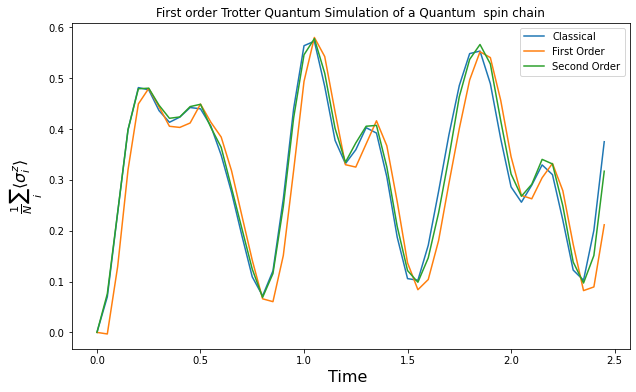

In [42]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tlist, sz_expt,label='Classical')
ax.plot(tlist, z_expect_list1,label='First Order')
ax.plot(tlist, z_expect_list2,label='Second Order')
ax.legend(loc=0)
ax.set_xlabel(r'Time ',fontsize=16)
ax.set_ylabel(r'$\frac{1}{N}\sum_i\langle \sigma^z_i \rangle$',fontsize=16)
ax.set_title(r'First order Trotter Quantum Simulation of a Quantum  spin chain');

# Error Analysis

In [21]:
si = qt.qeye(2)
sx=qt.sigmax()
sz=qt.sigmaz()
sx_list = []
sz_list = []
for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)
    op_list[n] = sx
    sx_list.append(qt.tensor(op_list))
    op_list[n] = sz
    sz_list.append(qt.tensor(op_list))

Hint = 0
for n in range(N-1):
    Hint += - 0.5 * Jx * sx_list[n] * sx_list[n+1]
Hz=0
for n in range(N):
    Hz += - 0.5 * hz * sz_list[n]
comm_HintHz=qt.commutator(Hint,Hz)
comm_norm=np.real(np.sqrt(np.max(np.linalg.eig(np.array((comm_HintHz.dag()*comm_HintHz).data.todense()))[0])))
errorbound=2*np.arange(50)*Δt**2*comm_norm

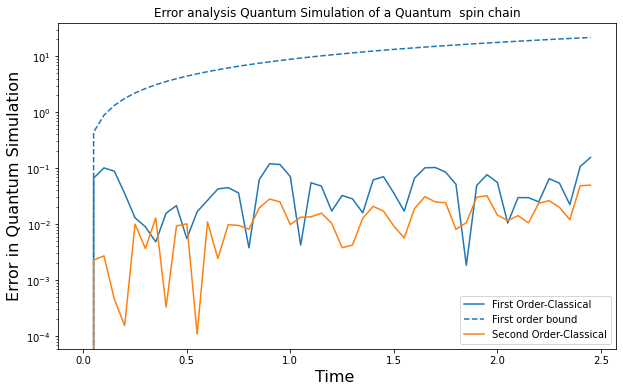

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tlist,np.abs(np.array(z_expect_list1) -np.array(sz_expt)),c='C0',label='First Order-Classical')
plt.plot(tlist,errorbound,'--',c='C0',label="First order bound")
ax.plot(tlist, np.abs(np.array(z_expect_list2) -np.array(sz_expt)),c='C1',label='Second Order-Classical')
ax.set_yscale('log')
ax.legend(loc=0)
ax.set_xlabel(r'Time ',fontsize=16)
ax.set_ylabel(r'Error in Quantum Simulation',fontsize=16)
ax.set_title(r'Error analysis Quantum Simulation of a Quantum  spin chain');